## Import Packages

In [1]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd

import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import rioxarray
from shapely.geometry import mapping
import networkx as nx


<ipython-input-1-d76e37e3598f>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [3]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

gateway.list_clusters()

[ClusterReport<name=prod.cf751bfcbe5440ef8a4a32bc66b4c224, status=RUNNING>]

## Scale cluster and connect a client
"cluster" will show the interactive scaling controls and the dashboard link, which can be pasted into the Dask labextension.

In [4]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [5]:
client

<Client: 'tls://10.36.27.112:8786' processes=0 threads=0, memory=0 B>

In [6]:
cd REMAWaterRouting/

[Errno 2] No such file or directory: 'REMAWaterRouting/'
/home/jovyan


pip install dask_image

import dask_image.ndfilters


# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

<AxesSubplot:>

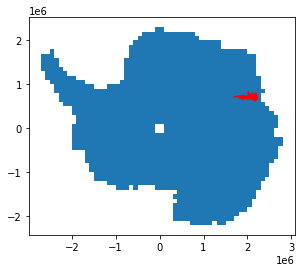

In [7]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('data/IceShelf_Antarctica_v02.shp') 

#select an ice shelf, the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']

#read in the REMA tile index
REMA_index = gpd.read_file('data/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Amery.geometry.plot(ax=axis,color='r')

In [8]:
#bounding box of ice shelf
[minx,miny,maxx,maxy]= Amery.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(col.min(),col.max()):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data

  0%|          | 0/2 [00:00<?, ?it/s]

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

### The following is a number of functions translated from Matlab's TopoToolbox to calculate drainage catchements from a DEM:

In [9]:
def flag_nans(dem):
    log_nans = np.isnan(dem);
         # handle NaNs

    if np.any(log_nans):
        flag_nans = 1;
    else:
        flag_nans = 0;
    return flag_nans

In [10]:
def identifyflats(dem):
    flats=np.zeros(dem.size)
    
        # handle NaNs
    #log_nans = np.isnan(dem);

    if flag_nans==True:
        #flag_nans = 1;
        dem = dask.array.nan_to_num(dem)#, nan=-np.inf) 
    else:
       # flag_nans = 0;
        dem = dem


    nhood = np.ones((3,3))
    # identify flats
    # flats: logical matrix with true where cells don't have lower neighbors

    if len(dem)>1:
        flats = skimage.morphology.erosion(image=dem,selem=nhood) == dem;

        #remove flats at the border
        flats[0:-1,[1, -1]]  = 0;
        flats[[0 -1],0:-1]  = 0;

        flats = skimage.segmentation.clear_border(flats, buffer_size=2)

       # if flag_nans==1:
        #    # remove flat pixels bordering to nans
         #   flats[skimage.morphology.dilation(image=log_nans,selem = nhood)] = 0
    return flats

In [11]:
def identifysills(dem,flats):
    # identify sills
    sills=np.zeros(dem.size)
    
    
    log_nans = np.isnan(dem);

    # find sills and set marker
    if len(dem)>1:
        Imr = -np.inf * np.ones(flats.shape);
        Imr[flats.astype(int)] = 0;
        maskeddem = np.multiply(dem,flats)
        Imr = Imr + maskeddem;
        Imr = (skimage.morphology.dilation(image=Imr,selem=nhood) == dem) & np.logical_not(flats);

        if flag_nans==True:
               Imr[log_nans] = 0;

        sills = Imr
    return sills

In [12]:
def identifyinteriorbasins(dem):
    log_nans = np.isnan(dem);

    # identify interior basins
    interiorbasins=np.zeros(dem.size)

    if len(dem)>1:
        interiorbasins = skimage.morphology.local_minima(dem);

        if flag_nans==1:
            interiorbasins = skimage.morphology.local_minima(dem);
            interiorbasins = np.bitwise_or(interiorbasins,log_nans);
            if interiorbasins.shape[0]>0:
                interiorbasins = skimage.segmentation.clear_border(interiorbasins, buffer_size=0);
                interiorbasins= np.multiply(interiorbasins,log_nans)
    else:
        if interiorbasins.shape[0]>0:
            interiorbasins = skimage.segmentation.clear_border(interiorbasins);

    return interiorbasins

In [13]:
import heapq
from imageio import imread


DIR_STRINGS = ["left", "down", "right", "up"]
DIRS = ((-1, 0), (0, -1), (1, 0), (0, 1))

def map_image_to_costs(D, PreSillPixel):
    """
    Read image data and convert it to a marginal cost function,
    a 2D array containing costs for moving through each pixel.
    This cost field forms the input for the weighted distance transform
    zero costs denote exits, infinite costs denote fully impenetrable obstacles.
    In this example, we follow Mercurial standards: obstacles are in black, exits in green,
    accessible space is in white, less accessible space has less white.
    Adapt to your own needs.
    :param image: String of image file or open file descriptor of image
    :return: 2D array representing the cost field
    """
    
    G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
    if len(PreSillPixel)>0:
        for pair in PreSillPixel:
            PSPx = int(pair[0])
            PSPy = int(pair[1])

        #R = abs(D)*255/np.max(abs(D))

        G[PSPx,PSPy] = 1
        #B = abs(D)*255/np.max(abs(D)
    
    data = G*256
    # Exits are present in all green enough places ("G >> R and G")
    exits = np.where(data >= 255 )
    # Obstacles are in black (so at least G and B must be zero)
    obstacles = np.where(data < 1)
    # Convert image to greyscale
    grey_scales = data
    # Boolean index array for places without exits and obstacles
    space = np.ones(grey_scales.shape, dtype=np.bool)
    space[obstacles] = False
    space[exits] = False
    # Cost field: Inversely proportional to greyscale values
    cost_field = np.empty(data.shape)
    cost_field[obstacles] = np.inf
    cost_field[exits] = 0
    cost_field[space] = 1. / (grey_scales[space])
    return cost_field

def _wdt_python(cost_field):
    """
    See `get_weighted_distance_transform`
    :param cost_field: 2D array
    :return: Weighted distance transform array with same shape as `cost_field`
    """
    nx, ny = cost_field.shape
    # Cost for moving along horizontal lines
    costs_x = np.ones([nx + 1, ny], order='F') * np.inf
    costs_x[1:-1, :] = (cost_field[1:, :] + cost_field[:-1, :]) / 2
    # Cost for moving along vertical lines
    costs_y = np.ones([nx, ny + 1], order='F') * np.inf
    costs_y[:, 1:-1] = (cost_field[:, 1:] + cost_field[:, :-1]) / 2

    # Initialize locations (known/unknown/exit/obstacle)
    weighted_distance_transform = np.ones_like(cost_field, order='F') * np.inf
    exit_locs = np.where(cost_field == 0)
    obstacle_locs = np.where(cost_field == np.inf)
    weighted_distance_transform[exit_locs] = 0

    # Initialize Cell structures
    all_cells = {(i, j) for i in range(nx) for j in range(ny)}
    known_cells = {cell for cell in zip(exit_locs[0], exit_locs[1])}
    unknown_cells = all_cells - known_cells - {cell for cell in zip(obstacle_locs[0], obstacle_locs[1])}
    new_candidate_cells = set()
    for cell in known_cells:
        new_candidate_cells |= _get_new_candidate_cells(cell, unknown_cells)
    cand_heap = [(np.inf, cell) for cell in new_candidate_cells]
    # Loop until all unknown cells have a distance value
    if len(cand_heap)>0:
        while True:
            # by repeatedly looping over the new candidate cells
            for cell in new_candidate_cells:
                # Compute a distance for each cell based on its neighbour cells
                distance = _propagate_distance(cell, [costs_x, costs_y], weighted_distance_transform)
                # Store this value in the heap (for fast lookup)
                # Don't check whether we have the distance already in the heap; check on outcome
                heapq.heappush(cand_heap, (distance, cell))
            # See if the heap contains a good value and if so, add it to the field. If not, finish.
            # Since we can store multiple distance values for one cell, we might need to pop a couple of times
            while True:
                min_distance, best_cell = heapq.heappop(cand_heap)
                if weighted_distance_transform[best_cell] == np.inf:
                    # Got a good one: no assigned distance in wdt yet
                    break
                elif min_distance == np.inf:  # No more finite values; done
                    return weighted_distance_transform
            # Good value found, add to the wdt and
            weighted_distance_transform[best_cell] = min_distance
            unknown_cells.remove(best_cell)
            new_candidate_cells = _get_new_candidate_cells(best_cell, unknown_cells)
    else:
        weighted_distance_transform = scipy.ndimage.distance_transform_edt(cost_field)+1
        return weighted_distance_transform
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)
def _exists(index, nx, ny):
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)


def _get_new_candidate_cells(cell, unknown_cells):
    """
    Compute the new candidate cells (cells for which we have no definite distance value yet
    For more information on the algorithm: check fast marching method
    :param cell: tuple of index; a new cell that has been added to the distance field
    :param unknown_cells: set of tuples; all cells still unknown
    :return: Set of new candidate cells for which to compute the distance
    """
    new_candidate_cells = set()
    for direction in DIRS:
        nb_cell = (cell[0] + direction[0], cell[1] + direction[1])
        if nb_cell in unknown_cells:
            new_candidate_cells.add(nb_cell)
    return new_candidate_cells


def _propagate_distance(cell, costs, wdt_field):
    """
    Compute the weighted distance in a cell using costs and distances in other cells
    :param cell: tuple, index of a candidate cell
    :param costs: list of cost arrays in X and Y direction
    :param wdt_field: the weighted distance transform field up until now
    :return: a approximate distance based on the neighbour cells
    """
    nx, ny = wdt_field.shape
    # Find the minimal directions along a grid cell.
    # Assume left and below are best, then overwrite with right and up if they are better
    adjacent_distances = np.ones(4) * np.inf
    pots_from_axis = [0, 0]  # [x direction, y direction]
    costs_from_axis = [np.inf, np.inf]  #
    for i, dir_s in enumerate(DIR_STRINGS):
        # Direction for which we check the cost
        normal = DIRS[i]
        nb_cell = (cell[0] + normal[0], cell[1] + normal[1])
        if not _exists(nb_cell, nx, ny):
            continue
        pot = wdt_field[nb_cell]
        # distance in that neighbour field
        if dir_s == 'left':
            face_index = (nb_cell[0] + 1, nb_cell[1])
        elif dir_s == 'down':
            face_index = (nb_cell[0], nb_cell[1] + 1)
        else:
            face_index = nb_cell
        # Left/right is x, up/down is y
        cost = costs[i % 2][face_index]
        # Proposed cost along this direction
        adjacent_distances[i] = pot + cost
        # If it is cheaper to go from the opposite direction
        if adjacent_distances[i] < adjacent_distances[(i + 2) % 4]:
            pots_from_axis[i % 2] = pot
            costs_from_axis[i % 2] = cost
        hor_pot, ver_pot = pots_from_axis
        hor_cost, ver_cost = costs_from_axis
        # Coefficients of quadratic equation (upwind discretization)
    a = 1. / hor_cost ** 2 + 1. / ver_cost ** 2
    b = -2 * (hor_pot / hor_cost ** 2 + ver_pot / ver_cost ** 2)
    c = (hor_pot / hor_cost) ** 2 + (ver_pot / ver_cost) ** 2 - 1

    D = b ** 2 - 4 * a * c
    # Largest root represents upwind approximation
    x_high = (2 * c) / (-b - math.sqrt(D+0.001)) #edited to prevent divide by zero errors
    return x_high


In [14]:
def drainagebasins(Z,flats,sills,interiorbasins, cellsize):  
    
    #[Iobj,SILLS,IntBasin] = identifyflats(Z);
    Z = Z.data
    Z_ravel = np.ravel(Z)
    nrc = Z_ravel.shape[0]
    
    Iobj  = flats
    SILLS = sills
    IntBasin = interiorbasins

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(np.bitwise_not(IntBasin));
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(1,np.max(IntBasin_labels)):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<Z.shape[0], colp<Z.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];
        I1 = np.ravel_multi_index([np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])],Z.shape)
        I2 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])],Z.shape)
        I3 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])], Z.shape)
        PreSillPixelCondition = (np.argwhere(np.bitwise_and((Z_ravel[I1] == Z_ravel[I2]), Iobj.ravel()[I3])))         
        if np.count_nonzero(PreSillPixelCondition)>0:
            for i in np.arange(0,len(PreSillPixelCondition)):
                PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i]],IXPreSill[1][PreSillPixelCondition[i]]])
                PreSillPixel.append(PreSillPixelAddition)
            else:
                continue
    PreSillPixel.pop(0);
        

    Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    masked = np.inf * np.ones(Z.shape,D.dtype); 
    masked[Iobj] = 0;
    D[np.bitwise_not(Iobj)]=np.inf
    D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
    D = np.nan_to_num(D)   

    D[Iobj] = 0
    #D = D**-1
    cost_field  = map_image_to_costs(D**-1,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[Iobj] = -np.inf
    
    del PreSillPixel
    D = np.reshape(D.data,[1,D.shape[0]*D.shape[1]])
    if np.any(np.isnan(np.diff(D.ravel()))):
        IXSortedFlats = np.arange(0,len(Z_ravel))
        IXSortedFlats = IXSortedFlats[::-1]
    else:
        IXSortedFlats = np.argsort(D.ravel());
        IXSortedFlats = IXSortedFlats[::-1]
    del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    
    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(Z_ravel[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    del ndx

     # a fast solution that has quite much memory overhead...
    pp = np.zeros(Z_ravel.shape,dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(Z_ravel.shape));
    pp[ix] = IX;
    pp = pp.reshape(Z.shape)
    
    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];
    
    G1   = (Z_ravel[ix]-Z_ravel[IXC1])/(cellsize);
    I4 = (np.argwhere(ix == IXC1)).ravel()

    I4 = list(I4)
    I4_test = np.zeros(G1.shape)
    I4_test[I4] = -np.inf
    G1 = G1 + I4_test;
    G1[ix == IXC1] = -np.inf; #Turned back on

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (Z_ravel[ix]-Z_ravel[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    #I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    I  = dask.array.bitwise_and(dask.array.less_equal(G1,G2),xxx2[ix]>xxx1[ix])
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];

    # remove nans
    I = np.isnan(Z_ravel);
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])
    
    DBcounter = 0;
    D = np.zeros(Z_ravel.shape[0],dtype=np.int32);
    outlets=np.zeros((len(ix),1))
    for r in np.arange(len(ix)-1,1,-1):
        if D[ixc[r]] == 0:
            DBcounter = DBcounter+1;
            D[ixc[r]] = DBcounter;
            outlets[DBcounter] = ixc[r];

        D[ix[r]] = D[ixc[r]];

    D = D.reshape(Z.shape)
    return D

In [15]:
n=6
part = 2
#nl_mean=True

coarsed_masked_array = ds_array.coarsen(x=n,y=n).mean()

coarsed_masked_array.shape

(4166, 12500)

In [16]:
coarsed_masked_array = coarsed_masked_array.chunk((1500,1500))

if part==1:
    sample  = coarsed_masked_array[:,0:int(coarsed_masked_array.shape[1]/2)]
if part>1:
    sample  = coarsed_masked_array[:,(part-1)*int(coarsed_masked_array.shape[1]/2):part*int(coarsed_masked_array.shape[1]/2)]

sample

<xarray.DataArray (y: 4166, x: 6250)>
dask.array<getitem, shape=(4166, 6250), dtype=float32, chunksize=(1500, 1500), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 8e+05 7.999e+05 7.999e+05 ... 6.001e+05 6.001e+05
  * x        (x) float64 1.9e+06 1.9e+06 1.9e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [17]:
cluster.scale(18)

In [228]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
#measures.to_zarr(mapper, mode='w');

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

atangent = dask.array.arctan(measures_dask.VX.data,measures_dask.VY.data)

measures_dask=measures_dask.assign(orientation =(['y','x'], atangent))

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [229]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [259]:
def image_destriping(array, vel_array):
    #from Destriping_functions import Lloyd_destripe, Guan_destripe, Rogass_destripe,\
    #Pande_Chhetri_destripe, Pystripe_destripe, RMSE_metric, SSIM_metric, PSNR_metric
    #from Oblique_destriping_functions import striping_angle, grad_image,\
    #super_Gauss_filter, refinement_destriping
    
        
    #Use a Frangi filter to identify any linear features, then create a label array to "blobbify" them 
    labelled = skimage.morphology.label(skimage.filters.frangi(array)>0.00001)
    #Calculate the orientation, find any larger than 500 pixels, return rounded CW angle
    stats = skimage.measure.regionprops_table(labelled, properties={'label', 'area','orientation','major_axis_length'})
    index = np.argwhere(stats['area']>500)
    stripe_orientations = np.round(-(stats['orientation'][index]),2)
    #Identify linear features that are aligned to ice flow +-0.1 rads = 5.7 deg 
    is_flow_stripe = np.abs(stripe_orientations - np.single(np.round(vel_array.mean(),2)))<0.1
    #Find the orientation of artifact stripes
    theta = np.rad2deg(np.median(stripe_orientations[~is_flow_stripe]))
    #Apply a rotated Fourier filter
    Ly_i = np.shape(array)[0]
    Lx_i = np.shape(array)[1]

    N_pad = 2000
    padded_patch = np.zeros((Ly_i+2*N_pad,Lx_i+2*N_pad))
    padded_patch[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i] = np.array(array)

    Ly_p = Ly_i + 2*N_pad
    Lx_p = Lx_i + 2*N_pad

    M_forward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),theta,1)
    array_rot = cv2.warpAffine(padded_patch,M_forward,(Lx_p,Ly_p))

    padded_array_rot = np.copy(array_rot)
    padded_array_rot[array_rot==0] = np.mean(array.data[array.data>0])
    M_backward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),-theta,1)
    # refine guess of stripe contribution to image
    Lloyd_destriped = Lloyd_destripe(padded_array_rot,0.5*Lx_p,140)
    destriped_array_ref = refinement_destriping(array_rot,Lloyd_destriped)

    destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                           (Lx_p,Ly_p))

    destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]
    
    #Apply a final gaussian filter
    destriped_image = skimage.filters.gaussian(destriped_image,2)
    destriped_image_xr = xr.DataArray(destriped_image,coords = array.coords)

    return destriped_image_xr

In [260]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
measures_resampled = measures_clipped.interp_like(sample)

chunks_y, chunks_x = sample.chunks
measures_resampled = measures_resampled.orientation.chunk({'x':chunks_x,'y':chunks_y})

In [262]:
cluster.scale(14)

In [263]:
def install():
    import os
    os.system("pip install opencv-python-headless")  # or pip


In [264]:
client.run(install)

{'tls://10.36.251.29:44681': None,
 'tls://10.36.94.226:34939': None,
 'tls://10.36.95.69:41235': None,
 'tls://10.37.17.38:39359': None,
 'tls://10.37.17.39:39175': None,
 'tls://10.37.20.35:36461': None,
 'tls://10.37.20.36:46785': None,
 'tls://10.37.40.17:43375': None,
 'tls://10.37.40.18:36023': None,
 'tls://10.37.50.17:33381': None,
 'tls://10.37.52.2:35965': None,
 'tls://10.37.53.2:44757': None,
 'tls://10.37.54.2:41651': None,
 'tls://10.37.7.26:36261': None}

In [265]:
destriped_sample_ = dask.array.map_blocks(lambda sample, velocity: image_destriping(sample,velocity),sample,measures_resampled.reindex_like(sample), dtype=float)

In [266]:
destriped_sample_ #= destriped_sample_.rechunk({0:-1,1:-1})

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [267]:
sample = destriped_sample_.compute()

In [19]:

aretherenans = dask.array.any(dask.array.isnan(sample.persist()))

In [20]:
aretherenans = aretherenans.compute()

In [21]:
flag_nans = aretherenans

# Part 1. Calculate water depths and basin hypsometry (Still in progress)

In [22]:
def dem_nonans(dem):
    dem_nonans = dem
    if aretherenans:
        dem_nonans = np.nan_to_num(dem, -9999)
    else:
        dem_nonans = dem
    return dem_nonans

def markers(dem):
    marker = np.negative(dem);
    II = np.zeros(dem.shape);
    II[1:-1,1:-1] = 1;
    II = np.bool_(II)
    #mask = np.zeros(dem.shape)
    if aretherenans:
        Inans  = np.isnan(dem)
        marker[np.bitwise_and(II,~Inans)] = -np.inf
    else:
        marker[II] = -np.inf
    #marker = marker+mask;
    return marker

def filledbasins(dem):
    dem = dem_nonans(dem)
    marker = markers(dem)
    demfs = -skimage.morphology.reconstruction(marker,np.negative(dem), method='dilation')
    return demfs

def remove_small_holes(dem):
    dem = dem_nonans(dem)
    marker = markers(dem)
    demfs = -skimage.morphology.reconstruction(marker,np.negative(dem), method='dilation')
    P_all = demfs - dem
    dem_fixed = np.multiply(demfs,P_all<0.01)+np.multiply(dem,P_all>0.1)
    #dem_fixed[P_all<0.01] = demfs[P_all<0.01]
    return dem_fixed

In [23]:
dem  = sample.persist()

dem = sample.map_blocks(dem_nonans, dtype=float)

demfs_ = dem.map_blocks(filledbasins, dtype=float)

demfs_

dask.array<filledbasins, shape=(4166, 6250), dtype=float64, chunksize=(1500, 1500), chunktype=numpy.ndarray>

In [24]:
cluster.scale(16)

In [25]:
demfs = demfs_.persist()

In [26]:
depths = demfs-sample

P_all = depths.compute()

In [27]:
import pandas  as pd

In [28]:
cellsize = (n*8)**2

dem_fixed = sample.map_blocks(remove_small_holes,dtype=float).persist()

dem_fixed

nhood = np.ones((3,3))
identified_flats = dem_fixed.map_blocks(identifyflats, dtype=float)


flats = identified_flats.persist()

identified_sills = dask.array.map_blocks(lambda dem,flats: identifysills(dem,flats), dem_fixed, identified_flats, dtype=float)#identifysills(sample_and_flats) #still would like to do this chunkwise

sills = identified_sills.persist()

identified_interbasins = dem_fixed.map_blocks(lambda dem: identifyinteriorbasins(dem), dtype=float)

interiorbasins = identified_interbasins.persist()

cellsize = (8*n)**2

FlowObj_dask = lambda dem,flats,sills,interiorbasins: drainagebasins(dem,flats,sills,interiorbasins,cellsize)

#flats  = flats
FlowObj_values = dask.array.map_blocks(FlowObj_dask,dem_fixed,flats,sills,interiorbasins, dtype=float)

#FlowObj_values=FlowObj_values.rechunk(5000)

FlowObj_values = FlowObj_values.rechunk(3000)
FlowObj_values

dask.array<rechunk-merge, shape=(4166, 6250), dtype=float64, chunksize=(3000, 3000), chunktype=numpy.ndarray>

In [29]:
cluster.scale(18)

In [30]:
DB = FlowObj_values.compute()

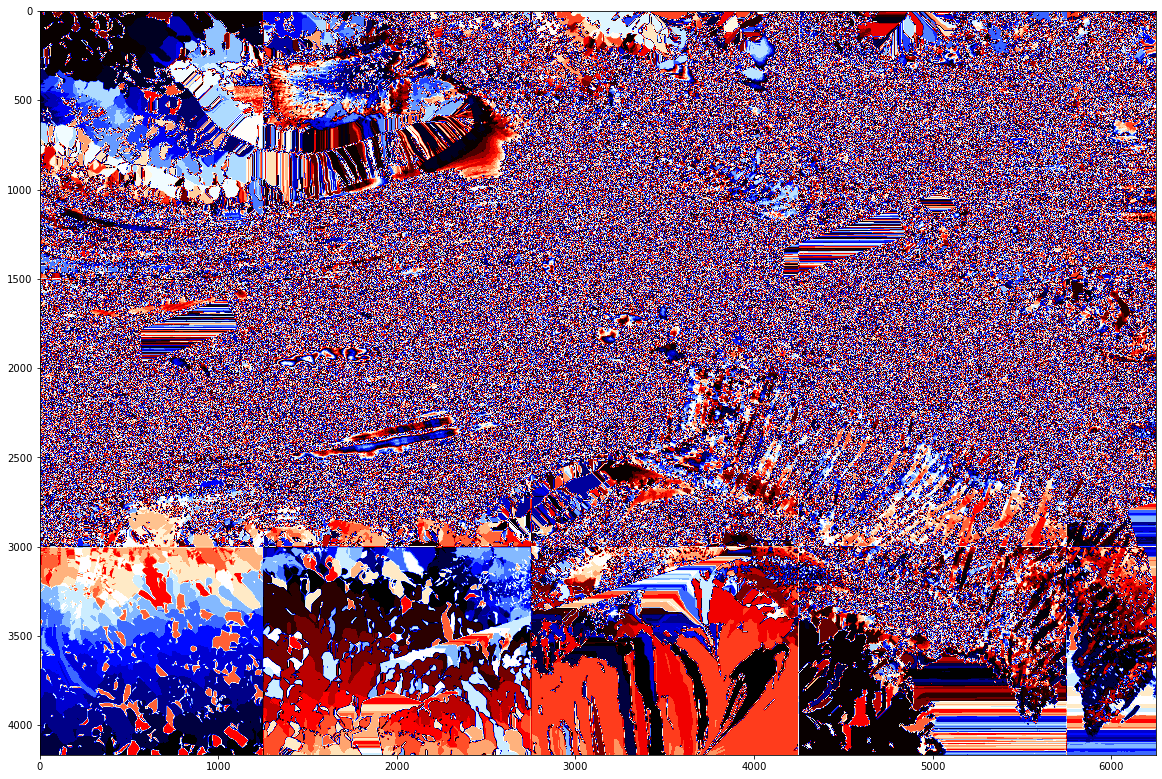

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(DB,cmap='flag')
#plt.plot(y,chunks_x[0]*np.ones(DB.shape[1]),'y')

In [32]:
x = np.arange(0,DB.shape[0])
y = np.arange(0,DB.shape[1])


In [33]:
#Step 1: Find the locations of the gridlines, determined by the chunksize.
#Cumulative sum gives the index of these in the intrinsic
chunks_x = np.cumsum(interiorbasins.chunks[0])
chunks_y = np.cumsum(interiorbasins.chunks[1])

chunks_x = chunks_x[chunks_x<DB.shape[0]]
chunks_y = chunks_y[chunks_y<DB.shape[1]]


def cleandrainagebasins(D, x, y):   
    D_labelled = skimage.morphology.label(D)

    D_labelled_new = D

    #merge down
    for i in chunks_x:
        topside = D[int(np.argwhere(x==i)),:]
        topside_values = np.argwhere(np.diff(topside)!=0)
        for ii in np.arange(0,len(topside_values)):
            col_to_merge = topside_values[ii]
            basin_to_merge = D_labelled[i,col_to_merge]
            #mask_right = np.argwhere(D_labelled == basin_to_merge)
            #[mask_x,mask_y] = np.array(mask_right).T
            D_labelled_new[D_labelled == basin_to_merge] = D[int(np.argwhere(x==i-1).squeeze()),topside_values[ii]]

    #Merge left
    for i in chunks_y:
        leftside = D_labelled[:,int(np.argwhere(y==i-1).squeeze())]
        leftside_values = np.argwhere(np.diff(leftside)!=0)
        for ii in np.arange(0,len(leftside_values)):
            row_to_merge = leftside_values[ii]
            basin_to_merge = D_labelled[row_to_merge,i]
            D_labelled_new[D_labelled == basin_to_merge] = D[leftside_values[ii],int(np.argwhere(y==i-1).squeeze())]
    
    #cleaned_DB = skimage.morphology.label(D_labelled_new)
    return D_labelled_new

In [34]:
DB_cleaned = cleandrainagebasins(DB,x,y)

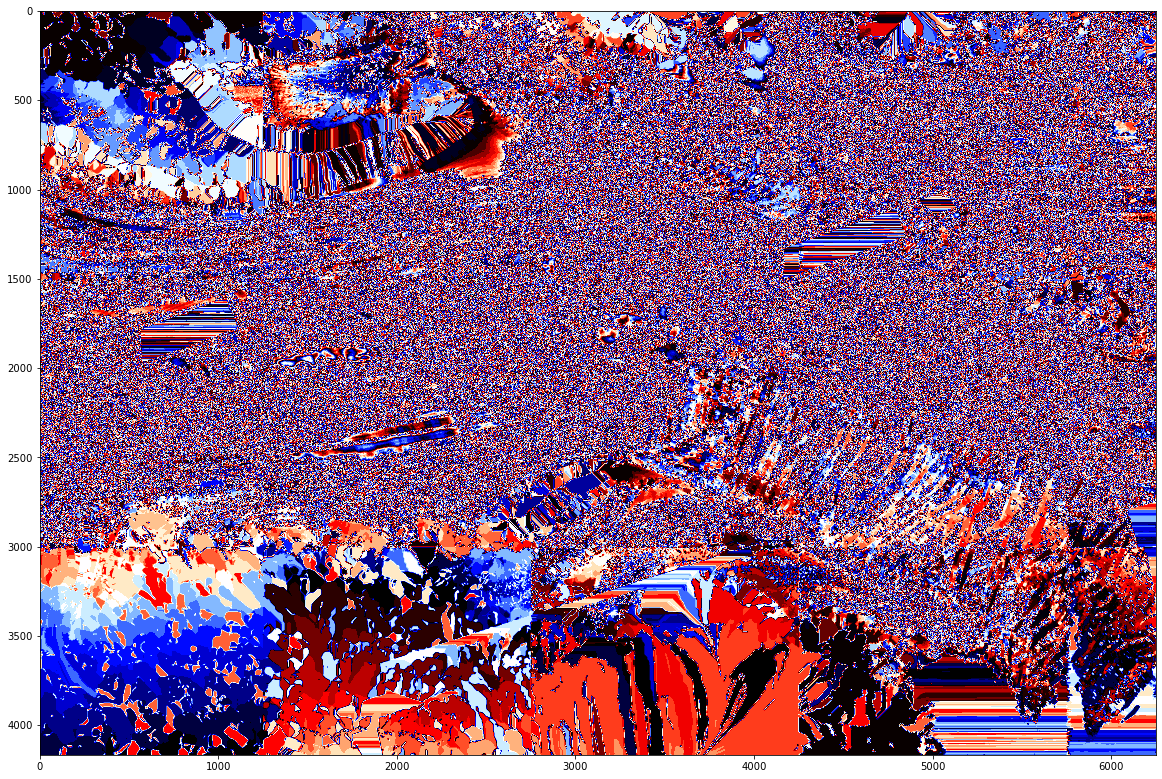

In [35]:
figure = plt.figure(figsize=(20,20))
plt.imshow(DB_cleaned,cmap='flag')

In [36]:
DB = dask.array.from_array(DB_cleaned)

In [37]:
if part==1:
    sample  = coarsed_masked_array[:,0:int(coarsed_masked_array.shape[1]/20)]
if part>1:
    sample  = coarsed_masked_array[:,(part-1)*int(coarsed_masked_array.shape[1]/2):part*int(coarsed_masked_array.shape[1]/2)]
Amery1 = xr.Dataset(data_vars=dict(
                            drainagebasins=(["y", "x"], DB_cleaned),
                            depressiondepth=(["y", "x"], P_all),
                        ),
                      coords = sample.coords,
                      attrs=sample.attrs)

In [38]:
filename = 'Amery_'+str(8*n)+'m_'
#if nl_mean:
 #   filename = filename+'nlmeans_'
if gaussian:
    filename = filename+'gaussian_'   
else:
    filename = filename+'fixed_'
filename = filename+str(part)+'.nc'
Amery1.to_netcdf(filename)

In [39]:
cluster.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p